In [4]:
import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder
from mpl_toolkits import mplot3d
from tensorflow.keras.layers import Input, Dense, LSTM, TimeDistributed, RepeatVector
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from scipy.spatial.distance import euclidean
import random
import seaborn as sns
from itertools import combinations, product
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [5]:
df1= pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2 = pd.read_csv('Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df3 = pd.read_csv('Friday-WorkingHours-Morning.pcap_ISCX.csv')
df4 = pd.read_csv('Monday-WorkingHours.pcap_ISCX.csv')
df5 = pd.read_csv('Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
df6 = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df7 = pd.read_csv('Tuesday-WorkingHours.pcap_ISCX.csv')
df8 = pd.read_csv('Wednesday-workingHours.pcap_ISCX.csv')
df = pd.concat([df1, df2, df3 , df4,df5,df6,df7,df8], ignore_index=True)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [6]:
np.random.seed(42)

# Sample a small subset of data for testing (e.g., 20%)
df = df.sample(frac=0.4, random_state=42)
test_df_http  =  df.sample(frac=0.2, random_state=42)
print(df.shape)
# Assuming obj is the object whose datatype you want to check
obj_type = type(df)
print(obj_type)


(819086, 79)
<class 'pandas.core.frame.DataFrame'>


In [7]:
# List all column names and their data types
column_datatypes = df.dtypes

# Print column names and their data types
for column_name, datatype in column_datatypes.items():
    print(f"Column: {column_name}, Datatype: {datatype}")

Column:  Destination Port, Datatype: int64
Column:  Flow Duration, Datatype: int64
Column:  Total Fwd Packets, Datatype: int64
Column:  Total Backward Packets, Datatype: int64
Column: Total Length of Fwd Packets, Datatype: int64
Column:  Total Length of Bwd Packets, Datatype: int64
Column:  Fwd Packet Length Max, Datatype: int64
Column:  Fwd Packet Length Min, Datatype: int64
Column:  Fwd Packet Length Mean, Datatype: float64
Column:  Fwd Packet Length Std, Datatype: float64
Column: Bwd Packet Length Max, Datatype: int64
Column:  Bwd Packet Length Min, Datatype: int64
Column:  Bwd Packet Length Mean, Datatype: float64
Column:  Bwd Packet Length Std, Datatype: float64
Column: Flow Bytes/s, Datatype: float64
Column:  Flow Packets/s, Datatype: float64
Column:  Flow IAT Mean, Datatype: float64
Column:  Flow IAT Std, Datatype: float64
Column:  Flow IAT Max, Datatype: int64
Column:  Flow IAT Min, Datatype: int64
Column: Fwd IAT Total, Datatype: int64
Column:  Fwd IAT Mean, Datatype: float64


In [8]:
def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df
df = clean_df(df)
test_df_http = clean_df(test_df_http)


dataset shape (819086, 79)
zero variance columns ['Bwd PSH Flags', 'Bwd URG Flags'] dropped
shape after removing zero variance columns: (819086, 77)
876 rows dropped
shape after removing nan: (818210, 77)
shape after dropping duplicates: (752921, 77)
columns which have identical values [('Fwd PSH Flags', 'SYN Flag Count'), ('Fwd URG Flags', 'CWE Flag Count'), ('Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk'), ('Fwd Avg Bytes/Bulk', 'Fwd Avg Bulk Rate'), ('Fwd Avg Bytes/Bulk', 'Bwd Avg Bytes/Bulk'), ('Fwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk'), ('Fwd Avg Bytes/Bulk', 'Bwd Avg Bulk Rate'), ('Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate'), ('Fwd Avg Packets/Bulk', 'Bwd Avg Bytes/Bulk'), ('Fwd Avg Packets/Bulk', 'Bwd Avg Packets/Bulk'), ('Fwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'), ('Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk'), ('Fwd Avg Bulk Rate', 'Bwd Avg Packets/Bulk'), ('Fwd Avg Bulk Rate', 'Bwd Avg Bulk Rate'), ('Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk'), ('Bwd Avg Bytes/Bulk', 'Bwd Av

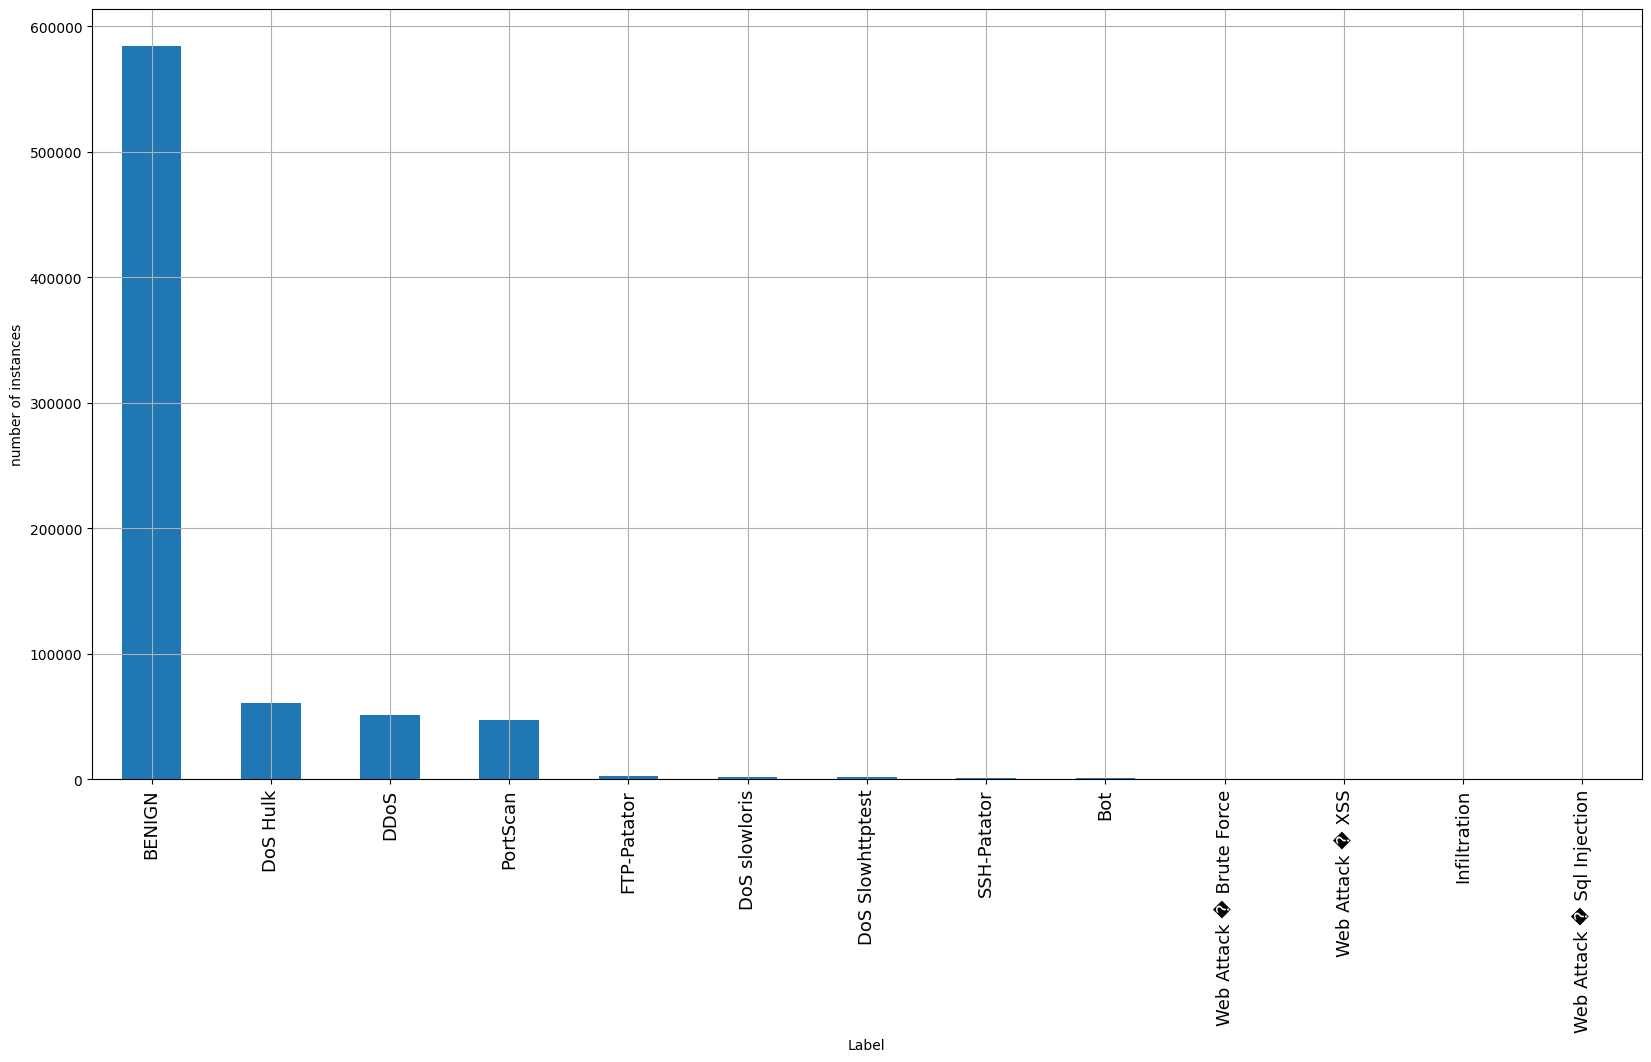

In [9]:
pd.value_counts(df['Label']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

In [10]:
normal_instances = df[df['Label']=='BENIGN'].shape[0]
anomalous_instances = df[df['Label']!='BENIGN'].shape[0]
print(normal_instances)
print(anomalous_instances)
print('percentage of anomalies = {}'.format(100*anomalous_instances/normal_instances))

584403
168518
percentage of anomalies = 28.83592315576751


In [11]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
1753692,53,149,2,2,46,46,23,23,23.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
335905,8383,17,1,1,2,6,2,2,2.0,0.0,...,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PortScan
648633,53,23703,2,2,62,184,31,31,31.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1304337,53,117783,2,2,58,400,29,29,29.0,0.0,...,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
178167,80,31011,5,0,30,0,6,6,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS


In [12]:
obj_type = type(df)
print(obj_type)

<class 'pandas.core.frame.DataFrame'>


In [13]:
df_http_normal = df[df['Label']=='BENIGN']
df_http_normal.drop(columns=['Label'], inplace=True)
df_http_normal.describe()

<ipython-input-13-24d37b209ab5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_http_normal.drop(columns=['Label'], inplace=True)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,584403.000000,5.844030e+05,584403.000000,584403.000000,5.844030e+05,5.844030e+05,584403.000000,584403.000000,584403.000000,584403.000000,...,584403.000000,584403.000000,5.844030e+05,5.844030e+05,5.844030e+05,5.844030e+05,5.844030e+05,5.844030e+05,5.844030e+05,5.844030e+05
mean,9108.016073,1.404964e+07,14.923852,17.691646,7.884537e+02,2.971859e+04,293.642031,22.421723,80.077887,98.320688,...,8.694124,25.590486,9.370624e+04,5.762521e+04,2.000420e+05,6.218451e+04,4.706393e+06,3.557654e+05,4.967854e+06,4.397945e+06
std,19451.681038,3.315624e+07,1132.110103,1515.961496,7.995419e+03,3.399030e+06,932.282849,73.337133,242.141004,371.501377,...,926.020755,6.277291,7.289882e+05,4.604044e+05,1.205604e+06,6.398316e+05,1.496052e+07,3.554933e+06,1.572438e+07,1.461779e+07
min,0.000000,0.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,53.000000,2.140000e+02,2.000000,1.000000,3.100000e+01,6.000000e+00,23.000000,0.000000,7.750000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,80.000000,4.969900e+04,2.000000,2.000000,6.800000e+01,1.360000e+02,44.000000,6.000000,40.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,443.000000,4.695932e+06,6.000000,5.000000,4.060000e+02,4.560000e+02,210.000000,40.000000,55.000000,75.070324,...,3.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65534.000000,1.200000e+08,217797.000000,289585.000000,2.428415e+06,6.396506e+08,24820.000000,2325.000000,4640.757576,6692.644993,...,207409.000000,138.000000,1.030000e+08,6.434950e+07,1.030000e+08,1.030000e+08,1.200000e+08,7.660000e+07,1.200000e+08,1.200000e+08


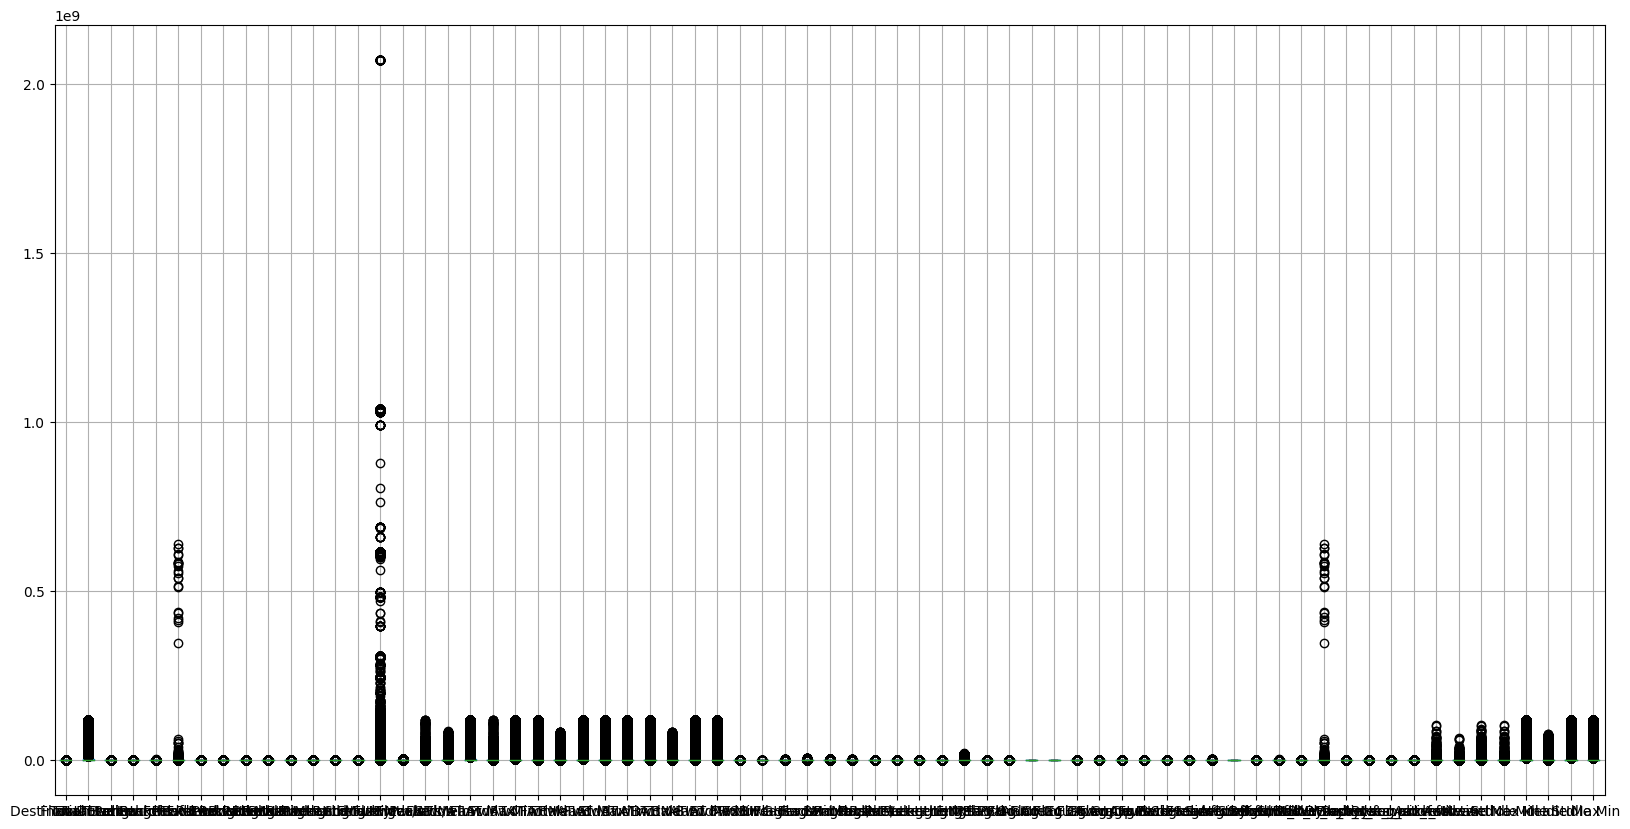

In [14]:
df_http_normal.boxplot(figsize=(20, 10))
plt.show()

In [15]:
# scaling the data using standard scaler
scaler = StandardScaler()
df_http_normal = pd.DataFrame(scaler.fit_transform(df_http_normal), columns=df_http_normal.columns)

In [16]:
# reducing the dimensionality of the data using PCA and covering 80% of the variance in the original data
pca = PCA(n_components=0.80)
pca.fit(df_http_normal)

PCA(n_components=0.8)

In [17]:
pca_cols = ['PCA_'+ str(i) for i in range(pca.n_components_)]
df_pca = pd.DataFrame(pca.transform(df_http_normal), columns=pca_cols)

In [18]:
df_pca.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11
0,-1.907668,0.124015,0.635050,0.040340,-0.598854,0.428556,-0.302532,-0.031412,-0.055697,0.306145,-0.070753,0.147585
1,-1.764291,0.132408,0.519135,-0.070207,-1.193799,0.633703,-0.135643,-0.088953,-0.301405,0.089304,-0.121152,-0.185726
2,-1.677313,0.167540,0.290373,-0.372561,-1.834256,0.628922,0.067864,-0.274059,-0.688653,-0.087025,0.342021,0.375573
3,-1.897719,0.117833,0.692060,0.650160,0.791089,0.019236,-0.366878,0.172713,0.457121,0.552701,-0.391056,0.042227
4,-1.825828,0.121431,0.552374,0.424154,0.940420,-0.120856,-0.468004,0.242986,0.670524,0.797726,-0.373503,0.243331


In [19]:
def get_windows(df, window_size=20, stride=10):
  windows_arr = []
  for i in tqdm.tqdm(range(0, len(df)-window_size+1, stride)):
    windows_arr.append(df.iloc[i:i+window_size, :].to_numpy())
  return np.array(windows_arr)

In [20]:
window_size, stride = 10, 10
windows_arr = get_windows(df_pca, window_size, stride)

100%|██████████| 58440/58440 [00:04<00:00, 14047.03it/s]


In [21]:
# shuffling windows for training purpose
indices = np.arange(windows_arr.shape[0])
np.random.shuffle(indices)
windows_shuffled = windows_arr[indices]

LSTM Autoencoder

In [26]:
K.clear_session()
# encoder model with stacked LSTM
encoder = Sequential([LSTM(80, return_sequences=True, activation='selu',input_shape=(window_size, 12), dropout=0.2), LSTM(50, activation='selu', return_sequences=True),
                      LSTM(20, activation='selu')], name='encoder')
# decoder model with output dimension same as input dimension
decoder = Sequential([RepeatVector(window_size), LSTM(50, activation='selu', return_sequences=True), LSTM(80, activation='selu',return_sequences=True),
                      TimeDistributed(Dense(12, activation='linear'))], name='decoder')
# creating sequential autoencoder using encoder, decoder as layers
autoencoder = Sequential([encoder, decoder], name='autoencoder')
autoencoder.compile(optimizer='adam', loss = tf.keras.losses.Huber(100.))
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 20)                61640     
                                                                 
 decoder (Sequential)        (None, 10, 12)            57092     
                                                                 
Total params: 118732 (463.80 KB)
Trainable params: 118732 (463.80 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
encoder.summary(), decoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 80)            29760     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            26200     
                                                                 
 lstm_2 (LSTM)               (None, 20)                5680      
                                                                 
Total params: 61640 (240.78 KB)
Trainable params: 61640 (240.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 repeat_vector (RepeatVecto  (None, 10, 20)            0         
 r)                                                              
    

(None, None)

In [28]:
check_point = tf.keras.callbacks.ModelCheckpoint('autoencoder.h5', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
train_hist = autoencoder.fit(windows_shuffled, windows_shuffled[:, :, ::-1], batch_size=64, validation_split=0.2, epochs=100, callbacks=[check_point])

Epoch 1/100
730/731 [============================>.] - ETA: 0s - loss: 1.4894
Epoch 1: val_loss improved from inf to 1.28056, saving model to autoencoder.h5
731/731 [==============================] - 62s 71ms/step - loss: 1.4892 - val_loss: 1.2806
Epoch 2/100
  1/731 [..............................] - ETA: 32s - loss: 0.9131

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


731/731 [==============================] - ETA: 0s - loss: 1.1769
Epoch 2: val_loss improved from 1.28056 to 1.19418, saving model to autoencoder.h5
731/731 [==============================] - 48s 66ms/step - loss: 1.1769 - val_loss: 1.1942
Epoch 3/100
731/731 [==============================] - ETA: 0s - loss: 1.0976
Epoch 3: val_loss improved from 1.19418 to 1.11170, saving model to autoencoder.h5
731/731 [==============================] - 47s 65ms/step - loss: 1.0976 - val_loss: 1.1117
Epoch 4/100
731/731 [==============================] - ETA: 0s - loss: 1.0569
Epoch 4: val_loss did not improve from 1.11170
731/731 [==============================] - 49s 67ms/step - loss: 1.0569 - val_loss: 1.1219
Epoch 5/100
730/731 [============================>.] - ETA: 0s - loss: 1.0323
Epoch 5: val_loss improved from 1.11170 to 1.03880, saving model to autoencoder.h5
731/731 [==============================] - 54s 74ms/step - loss: 1.0321 - val_loss: 1.0388
Epoch 6/100
730/731 [===================

In [29]:
# restoring the best model
autoencoder_loaded = tf.keras.models.load_model('autoencoder.h5')

Testing

In [37]:
df1= pd.read_csv('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')
df2 = pd.read_csv('Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
df3 = pd.read_csv('Friday-WorkingHours-Morning.pcap_ISCX.csv')
df4 = pd.read_csv('Monday-WorkingHours.pcap_ISCX.csv')
df5 = pd.read_csv('Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
df6 = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
df7 = pd.read_csv('Tuesday-WorkingHours.pcap_ISCX.csv')
df8 = pd.read_csv('Wednesday-workingHours.pcap_ISCX.csv')
df = pd.concat([df1, df2, df3 , df4,df5,df6,df7,df8], ignore_index=True)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [42]:
np.random.seed(42)

# Sample a small subset of data for testing (e.g., 20%)
test_df_http = df.sample(frac=0.2, random_state=42)

test_df_http = test_df_http.replace([np.inf, -np.inf], np.nan)  # Replace infinite values with NaN
test_df_http = clean_df(test_df_http)

dataset shape (566149, 79)
zero variance columns ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'] dropped
shape after removing zero variance columns: (566149, 71)
591 rows dropped
shape after removing nan: (565558, 71)
shape after dropping duplicates: (530424, 71)
columns which have identical values [('Total Fwd Packets', 'Subflow Fwd Packets'), ('Total Backward Packets', 'Subflow Bwd Packets'), ('Fwd Packet Length Mean', 'Avg Fwd Segment Size'), ('Fwd PSH Flags', 'SYN Flag Count'), ('Fwd URG Flags', 'CWE Flag Count'), ('Fwd Header Length', 'Fwd Header Length.1'), ('RST Flag Count', 'ECE Flag Count')] dropped
shape after removing identical value columns: (530424, 64)


In [45]:
# binary indicator to represent anomalies
status = pd.Series([0 if i=='BENIGN' else 1 for i in test_df_http['Label']])
test_labels = [1 if np.sum(status[i:i+window_size])>0 else 0 for i in range(0, len(status)-window_size+1, stride)]

In [46]:
test_df_http_pca = pd.DataFrame(pca.transform(test_df_http), columns=pca_cols)
test_df_http_pca.head()

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Label
Feature names seen at fit time, yet now missing:
- Avg Fwd Segment Size
- ECE Flag Count
- Fwd Avg Bytes/Bulk
- Fwd Header Length.1
- Subflow Bwd Packets
- ...


In [ ]:
test_windows = get_windows(test_df_http_pca, window_size=10, stride=10)

In [ ]:
test_windows_pred = autoencoder_loaded.predict(test_windows)

In [ ]:
# calculating reconstruction error for each sample
# implemented in tensorflow for faster execution when gpu is available

def get_recon_erros(true_windows, pred_windows):
  recon_errors = []

  def cond(y_true, y_pred, i, iters):
    return tf.less(i, iters)

  def body(y_true, y_pred, i, iters):
    tensor_for_error = tf.math.subtract(tf.slice(y_true, [i, 0, 0], [1, -1, -1]), tf.slice(y_pred, [i, 0, 0], [1, -1, -1]))
    tensor_for_error = tf.reshape(tensor_for_error, [window_size, pca.n_components_])
    recon_error = tf.math.reduce_mean(tf.norm(tensor_for_error, ord='euclidean', axis=1))
    # this is the list initialized above
    recon_errors.append(recon_error.numpy())
    return [y_true, y_pred, tf.add(i, 1), iters]

  iters = tf.constant(len(true_windows))

  result = tf.while_loop(cond, body, [tf.constant(true_windows.astype(np.float32)), tf.constant(pred_windows.astype(np.float32)), 0, iters])
  return recon_errors

In [ ]:
recon_errors = get_recon_erros(test_windows, test_windows_pred)
recon_errors = np.array(recon_errors).reshape(-1, 1)

In [ ]:
# scaling the reconstruction errors set to [0, 1] scale
mm_scaler = MinMaxScaler()
anomaly_scores = mm_scaler.fit_transform(recon_errors).flatten()

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(test_labels, c='blue', label='original')
plt.plot(anomaly_scores, c='red', label='predicted')
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.grid()
plt.legend()
plt.show()

Measuring the effectiveness of classifier

In [ ]:
fpr, tpr, thresholds = roc_curve(test_labels, anomaly_scores)

In [ ]:
auc = roc_auc_score(test_labels, anomaly_scores)
print('Area under ROC curve: {}'.format(auc))

In [ ]:
plt.figure(figsize=(10,5))
plt.plot([0, 1], [0, 1], color = 'black', linestyle='--')
plt.plot(fpr, tpr, label='AUC={}'.format(auc))
plt.grid()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.title('ROC')
plt.show()


Identifying anomalies in test set

In [ ]:
anomaly_combinations = [(anomaly_scores>i).astype(np.int32) for i in thresholds]
f1_scores = [f1_score(test_labels, i) for i in anomaly_combinations]

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores)
plt.grid()
plt.xlabel('Thresholds')
plt.ylabel('F-1 Score')
plt.title('F-1 Score vs Thresholds')
plt.show()

In [ ]:
max_f1_score = np.max(f1_scores)
best_threshold = thresholds[f1_scores.index(max_f1_score)]
print('best threshold = {}'.format(best_threshold))

In [ ]:
anomaly_indicator = (anomaly_scores>best_threshold).astype(np.int32)

In [ ]:
confusion_matrix(test_labels, anomaly_indicator)

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=np.arange(0, len(anomaly_scores)), y= anomaly_scores, hue=['normal' if i==0 else 'anomaly' for i in anomaly_indicator],
                palette=['blue', 'red'], legend='full')
plt.axhline(y = best_threshold, linestyle='--', label='threshold')
plt.xlabel('samples')
plt.ylabel('anomaly score')
plt.legend()
plt.grid()
plt.show()

In [ ]:
precision = precision_score(test_labels, anomaly_indicator)
recall = recall_score(test_labels, anomaly_indicator)
f1_sc = f1_score(test_labels, anomaly_indicator)
accuracy_sc = accuracy_score(test_labels, anomaly_indicator)

In [ ]:
print('Model has the following classification metrics:\n precision = {}\n recall = {}\n f1_score = {}\n accuracy_score = {}'
      .format(precision, recall, f1_sc, accuracy_sc))